In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
import torch
from torch.nn import MSELoss
from torchvision import transforms
from PIL import Image
from monai.networks.blocks import Warp
from monai.networks.nets import GlobalNet
from monai.losses import BendingEnergyLoss
import numpy as np

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
!unzip -qq /content/drive/MyDrive/MRI_data/2Dr_10000.zip;

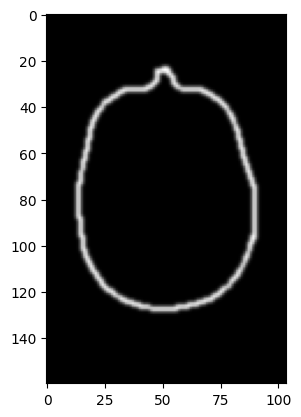

In [ ]:
import matplotlib.pyplot as plt
fixed = Image.open('/content/fixed_image0.png')
fixed = fixed.crop((48, 64, 152, 224)) #cropping to a more suitable size

#plt.figure("check", (12, 6))
plt.imshow(fixed, cmap="gray")

plt.show()

In [ ]:
device = torch.device("cuda:0")
n =  1001 #number of augmented images + 1
fixed = Image.open('/content/fixed_image0.png')
fixed = fixed.crop((48, 64, 152, 224)) #cropping to a more suitable size
convert_tensor = transforms.ToTensor()
fixed = convert_tensor(fixed)
fixed1 = fixed.unsqueeze(0)
fixed1 = fixed1.to(device)
print(fixed1.size())

list1 = []
for i in range (1,n):
  moving = Image.open(f'/content/train/00{i}_rt.png')
  moving = moving.crop((48, 64, 152, 224))
  moving = convert_tensor(moving)
  moving1 = moving.unsqueeze(0)
  moving1 = moving1.to(device)
  list1.append(moving1)

#inputt = torch.cat((fixed, moving), dim=1)

torch.Size([1, 1, 160, 104])


In [ ]:
#translations parameters - x and y are swapped for these coordinates vs mri ones, rotations are clockwise in degrees
rotations = []
for i in range(1, n):
    with open(f"/content/train/00{i}_augments.txt") as f:
        lines = f.readlines()

        line0 = lines[0]
        r = float(line0.split("=")[1])
        #convert to radians
        r = (r*np.pi)/180
        rotations.append(r)

In [ ]:
ddfs = []
for r in rotations:
  image_width = 104
  image_height = 160

  # Create mesh grid
  x, y = np.meshgrid(range(image_height), range(image_width), indexing='ij')

  # Initialize tensor
  displacement_field = np.zeros((image_height, image_width, 2))

  # Apply transformation parameters - affine transformation matrix: [[cos(r), sin(r), Tx], [-sin(r), cos(r), Ty]]
  homogeneous_coordinates = np.stack([x.flatten(), y.flatten(), np.ones_like(x.flatten())])
  transformation_matrix = np.array([[np.cos(r), np.sin(r), 0], [-np.sin(r), np.cos(r), 0]])
  transformed_homogeneous_coordinates = transformation_matrix @ homogeneous_coordinates

  # Compute displacement field
  displacement_field[..., 0] = transformed_homogeneous_coordinates[0].reshape((image_height, image_width)) - x
  displacement_field[..., 1] = transformed_homogeneous_coordinates[1].reshape((image_height, image_width)) - y

  displacementfield0 = torch.tensor(displacement_field)
  displacementfield = displacementfield0.unsqueeze(0)
  displacementfield = displacementfield.permute(0, 3, 1, 2)
  displacementfield = displacementfield.to(device)
  ddfs.append(displacementfield)

#print(ddfs[1])
print(ddfs[1].size())

torch.Size([1, 2, 160, 104])


In [ ]:
activation = {}


def get_activation(name):
    def hook(net, input, output):
        activation[name] = output.detach()

    return hook

def custom_loss(result, displacementfield):
    return torch.mean((result - displacementfield)**2)

input_param = {
    "image_size": (160, 104),
    "spatial_dims": 2,
    "in_channels": 2,
    "num_channel_initial": 16,
    "depth": 3,
}
net = GlobalNet(**input_param).to(device)
net.output_block.fc.register_forward_hook(get_activation("fc"))
regularization = BendingEnergyLoss()
optimizer = torch.optim.Adam(net.parameters(), 1e-5)

In [ ]:
def custom_loss1(result, displacementfield):
  transformed_points = fixed1 + result
  ground_truth_points = fixed1 + displacementfield

  # Compute Chamfer distance between transformed points and ground truth points
  return (torch.mean(torch.min(torch.sum((transformed_points[:, None, :] - ground_truth_points[None, :, :])**2, dim=2), dim=1).values) + torch.mean(torch.min(torch.sum((ground_truth_points[:, None, :] - transformed_points[None, :, :])**2, dim=2), dim=1).values))/2


Loading in a pre-trained model if need be

In [ ]:
#net.load_state_dict(torch.load('/content/drive/MyDrive/MRI_data/2transrot.pth'))
#net.eval()

In [ ]:
#number of trainable parameters,
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

Number of trainable parameters: 689862


In [ ]:
max_epochs = 20
epoch_loss_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    net.train()
    epoch_loss, step = 0, 0
    for (moving1, displacementfield) in zip(list1, ddfs):
        step += 1
        optimizer.zero_grad()
        result = net(torch.cat((fixed1, moving1), dim=1))
        loss = custom_loss(result, displacementfield) + 100 * regularization(result) #was 10 previously
        #loss = custom_loss1(result, displacementfield)
        #loss = customloss2(result, transmat)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

----------
epoch 1/20
epoch 1 average loss: 21.2820
----------
epoch 2/20
epoch 2 average loss: 16.7076
----------
epoch 3/20
epoch 3 average loss: 12.0780
----------
epoch 4/20
epoch 4 average loss: 5.9518
----------
epoch 5/20
epoch 5 average loss: 3.4952
----------
epoch 6/20
epoch 6 average loss: 5.1112
----------
epoch 7/20
epoch 7 average loss: 4.9908
----------
epoch 8/20
epoch 8 average loss: 2.4041
----------
epoch 9/20
epoch 9 average loss: 3.2736
----------
epoch 10/20
epoch 10 average loss: 1.8797
----------
epoch 11/20
epoch 11 average loss: 1.8675
----------
epoch 12/20
epoch 12 average loss: 1.9081
----------
epoch 13/20
epoch 13 average loss: 1.5389
----------
epoch 14/20
epoch 14 average loss: 2.1302
----------
epoch 15/20
epoch 15 average loss: 1.3833
----------
epoch 16/20
epoch 16 average loss: 1.6856
----------
epoch 17/20
epoch 17 average loss: 1.1176
----------
epoch 18/20
epoch 18 average loss: 1.2387
----------
epoch 19/20
epoch 19 average loss: 1.2445
--------

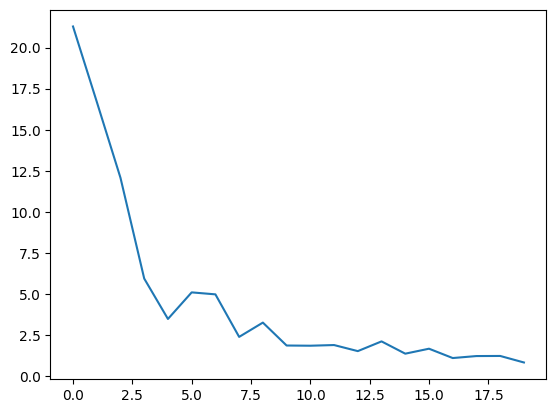

In [ ]:
%matplotlib inline
plt.plot(epoch_loss_values)

Now with validation data

In [ ]:
m = 101 #number of test data

list2 = []
for i in range (1,m):
  moving = Image.open(f'/content/test/00{i}_rt.png')
  moving = moving.crop((48, 64, 152, 224))
  moving = convert_tensor(moving)
  moving2 = moving.unsqueeze(0)
  moving2 = moving2.to(device)
  list2.append(moving2)

In [ ]:
activations = []
for moving2 in list2:
    ddf = net(torch.cat((moving2, fixed1), dim=1))
    #pred_image = warp_layer(moving2, ddf)
    #print(activation)
    #pred_image = pred_image.detach().cpu().numpy()[:, 0]
    activations.append(activation['fc'])

#activations[10]['fc'][0,2].item()

In [ ]:
#each activation is [[cos(r), sin(r), Tx], [-sin(r), cos(r), Ty]]
predx = []

for activation in activations:
  a = activation[0,2].item()
  predx.append(a)

predy = []

for activation in activations:
  b = activation[0,5].item()
  predy.append(b)

#now for rotations it will be a bit trickier as there are four outputs to get the angle from - only averaging over the sin angles as the cos values can overshoot 1
predr = []

for activation in activations:
  c = activation[0, 0].item()
  d = activation[0, 1].item()
  e = activation[0, 3].item()
  f = activation[0, 4].item()

  g = (np.arcsin(d) + np.arcsin(-e))/2
  predr.append(g)


In [ ]:
test_r = []
for i in range(1, m):
    with open(f"/content/test/00{i}_augments.txt") as f:
        lines = f.readlines()
        line0 = lines[0]
        r1 = float(line0.split("=")[1])
        #convert to radians
        r1 = (r1*np.pi)/180
        test_r.append(r1)

Checking that predicted values for translations are negligible

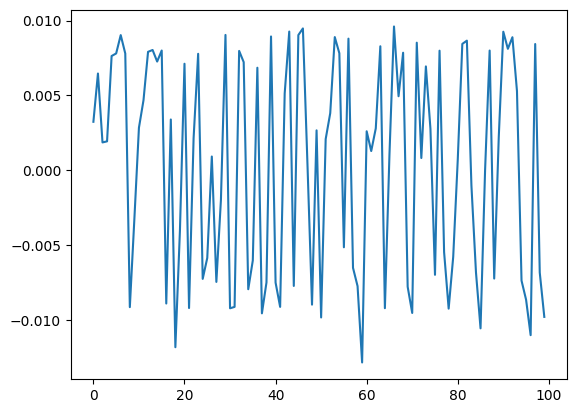

In [ ]:
%matplotlib inline
plt.plot(predx)

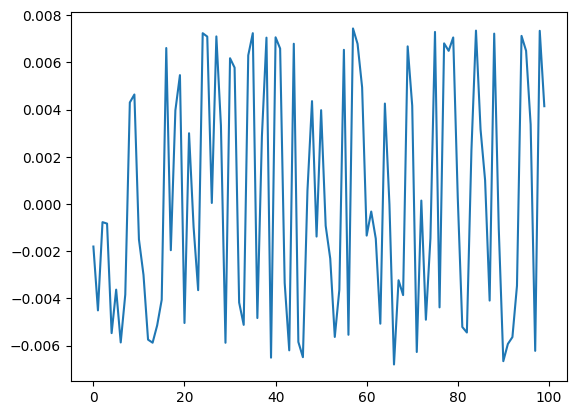

In [ ]:
%matplotlib inline
plt.plot(predy)

Plotting predicted rotations against ground truths

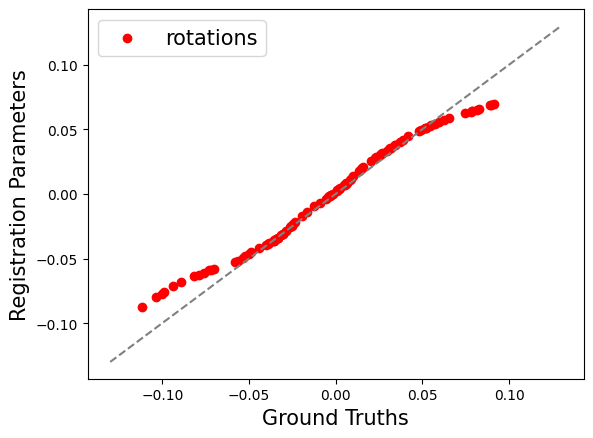

In [ ]:
%matplotlib inline
plt.scatter(test_r, predr, label="rotations", color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)

plt.legend(fontsize=15, loc='upper left')

plt.plot([-0.13, 0.13], [-0.13, 0.13], linestyle='--', color='gray')


In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/MRI_data/2Drot_04.pth')

Testing section